# I. Download Dataset from Kaggle

In [1]:
! pip install --user kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Upload kaggle.json from www.kaggle.com/<username>/account

In [3]:
! mkdir ~/.kaggle

In [4]:
! mv kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d sorour/38cloud-cloud-segmentation-in-satellite-images

100% 12.2G/12.2G [01:27<00:00, 167MB/s]
100% 12.2G/12.2G [01:27<00:00, 149MB/s]


In [7]:
! unzip -qq 38cloud-cloud-segmentation-in-satellite-images.zip -d 38cloud-cloud-segmentation-in-satellite-images/

In [8]:
! rm 38cloud-cloud-segmentation-in-satellite-images.zip

# II. Preparation

In [24]:
import os
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time

## Seeding 
seed = 1234
np.random.seed = seed
torch.manual_seed(seed)

In [3]:
#Enable GPU training 
USE_GPU = torch.cuda.is_available()
print('USE_GPU={}'.format(USE_GPU))
if USE_GPU:
    print('current_device={}'.format(torch.cuda.current_device()))

USE_GPU=True
current_device=0


# III. Create Dataloader

In [4]:
# reference to https://www.kaggle.com/cordmaur/38-cloud-simple-unet

class CloudDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, pytorch=True):
        super().__init__()
        
        # Loop through the files in red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(f, g_dir, b_dir, nir_dir, gt_dir) for f in r_dir.iterdir() if not f.is_dir()]
        self.pytorch = pytorch
        
    def combine_files(self, r_file: Path, g_dir, b_dir,nir_dir, gt_dir):
        
        files = {'red': r_file, 
                 'green':g_dir/r_file.name.replace('red', 'green'),
                 'blue': b_dir/r_file.name.replace('red', 'blue'), 
                 'nir': nir_dir/r_file.name.replace('red', 'nir'),
                 'gt': gt_dir/r_file.name.replace('red', 'gt')}

        return files
                                       
    def __len__(self):
        
        return len(self.files)
     
    def open_as_array(self, idx, invert=False, include_nir=False):

        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                           ], axis=2)
    
        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
    
        if invert:
            raw_rgb = raw_rgb.transpose((2,0,1))
    
        # normalize
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)
    

    def open_mask(self, idx, add_dims=False):
        
        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask==255, 1, 0)
        
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask
    
    def __getitem__(self, idx):
        
        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch, include_nir=True), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.torch.int64)
        
        return x, y


In [5]:
# create torch dataset like defined in CloudDataset class
base_path = Path('38cloud-cloud-segmentation-in-satellite-images/38-Cloud_training')
data = CloudDataset(base_path/'train_red', 
                    base_path/'train_green', 
                    base_path/'train_blue', 
                    base_path/'train_nir',
                    base_path/'train_gt')
len(data)

8400

In [6]:
# returns features x and target feature y
x, y = data[1000]
x.shape, y.shape

(torch.Size([4, 384, 384]), torch.Size([384, 384]))

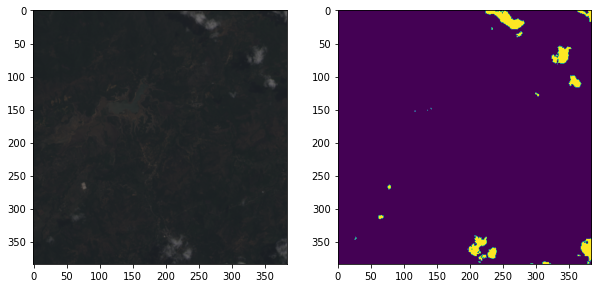

In [7]:
# visualize raw image and ground truth
image_index = 800

fig, ax = plt.subplots(1,2, figsize=(10,9))
ax[0].imshow(data.open_as_array(image_index))
ax[1].imshow(data.open_mask(image_index))

# left -> raw image
# right Ground-Truth Mask (as binary image)

In [8]:
train_dataset, valid_dataset = torch.utils.data.random_split(data, (6000, 2400))

In [9]:
sample_train_dataset = torch.utils.data.Subset(train_dataset, range(600))
sample_valid_dataset = torch.utils.data.Subset(valid_dataset, range(240))

In [10]:
# Create dataloads sample from dataset

train_dataload = DataLoader(sample_train_dataset, batch_size=3, shuffle=True)
valid_dataload = DataLoader(sample_valid_dataset, batch_size=3, shuffle=True)

In [11]:
# test dataload
xb, yb = next(iter(train_dataload))
xb.shape, yb.shape

(torch.Size([3, 4, 384, 384]), torch.Size([3, 384, 384]))

# IV. Train Function

In [19]:
import time
from IPython.display import clear_output

def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()
    model.cuda()

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dataload
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dataload

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 

                if step % 100 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            clear_output(wait=True)
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            print('-' * 10)

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.cuda()).float().mean()

# V. Predict Function

In [25]:
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

# VI. Models

## 1. UNET Version 1 ([From Kaggle](https://www.kaggle.com/code/cordmaur/38-cloud-simple-unet))

### 1.1 Model

In [19]:
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

In [20]:
unet = UNET(4,2)

In [21]:
# testing one pass
xb, yb = next(iter(train_dataload))
xb.shape, yb.shape

pred = unet(xb)
pred.shape

torch.Size([3, 2, 384, 384])

### 1.2 Training

In [23]:
loss_fn = nn.CrossEntropyLoss() # choose loss function
opt = torch.optim.Adam(unet.parameters(), lr=0.01) # choose gradient function

# start training
train_loss, valid_loss = train(unet, train_dataload, valid_dataload, loss_fn, opt, acc_metric, epochs=2)

Epoch 1/1
----------
valid Loss: 0.4792 Acc: 0.7405419945716858
----------
Training complete in 1m 3s


In [24]:
train_loss

[tensor(0.4941, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.4209, device='cuda:0', grad_fn=<DivBackward0>)]

In [25]:
valid_loss

[tensor(0.3456, device='cuda:0'), tensor(0.4792, device='cuda:0')]

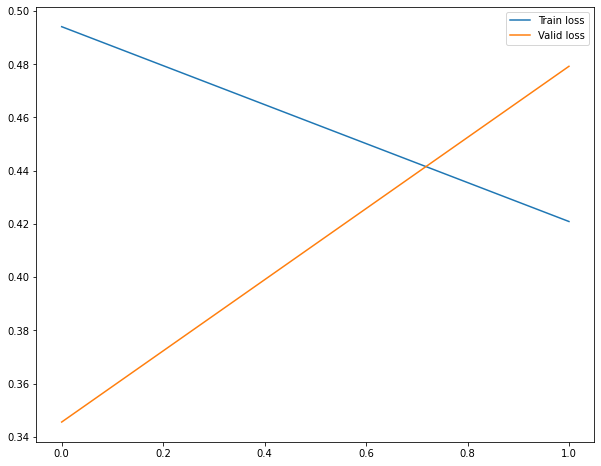

In [26]:
# visualize Result
plt.figure(figsize=(10,8))
plt.plot([loss.cpu().data for loss in train_loss], label='Train loss')
plt.plot([loss.cpu().data for loss in valid_loss], label='Valid loss')
plt.legend()

### 1.3 Prediction

In [28]:
xb, yb = next(iter(train_dataload))

with torch.no_grad():
    predb = unet(xb.cuda())

predb.shape

torch.Size([3, 2, 384, 384])

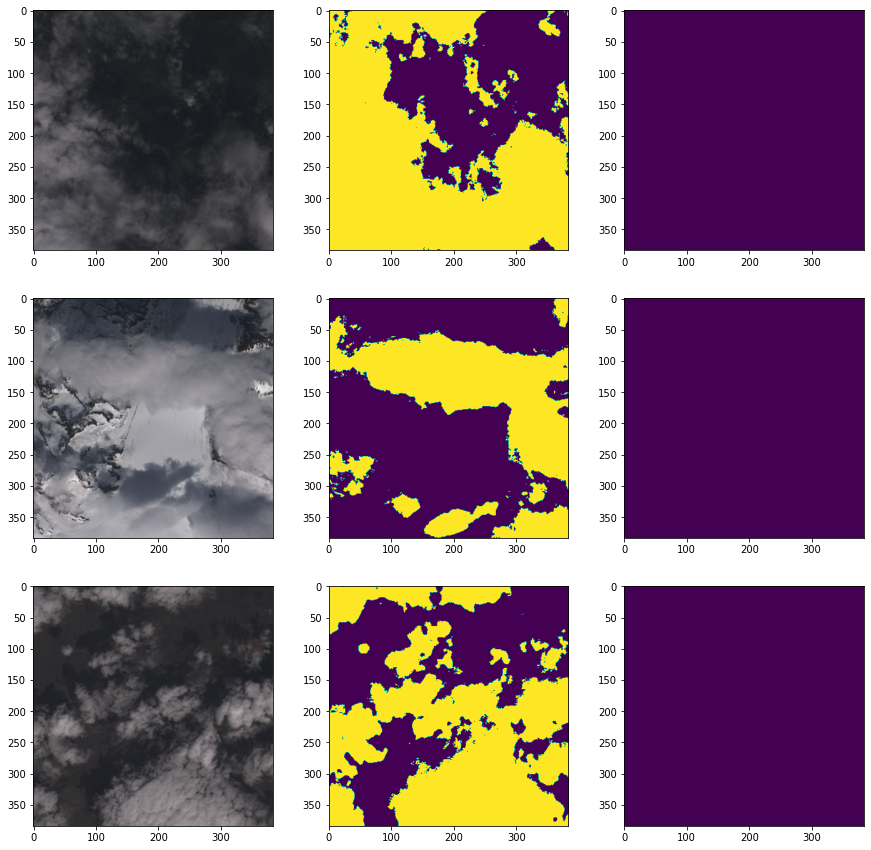

In [29]:
bs = 3
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))

## 2. UNET Version 2 ([From DenseUnet](https://github.com/NYUMedML/DARTS/blob/master/DARTS/models/unet.py))

### 2.1 Model

In [30]:
class Downsample_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x)))
        y = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(y, 2,stride = 2)
        
        return x, y  
    
class Upsample_block(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Upsample_block, self).__init__()
        self.transconv = nn.ConvTranspose2d(in_channels, out_channels, 4, padding = 1, stride = 2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self,x, y):
        x = self.transconv(x)
        x = torch.cat((x,y),dim = 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        
        return x
    
class Unet(nn.Module):
    def __init__(self,in_chan = 3, out_chan = 3):
        super(Unet, self).__init__()
        self.down1 = Downsample_block(in_chan,64)
        self.down2 = Downsample_block(64,128)
        self.down3 = Downsample_block(128,256)
        self.down4 = Downsample_block(256,512)
        self.conv1 = nn.Conv2d(512,1024, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.conv2 = nn.Conv2d(1024,1024,3, padding = 1)
        self.bn2 = nn.BatchNorm2d(1024)
        self.up4 = Upsample_block(1024,512)
        self.up3 = Upsample_block(512,256)
        self.up2 = Upsample_block(256,128)
        self.up1 = Upsample_block(128,64)
        self.outconv = nn.Conv2d(64,out_chan, 1)
        self.outconvp1 = nn.Conv2d(64,out_chan, 1)
        self.outconvm1 = nn.Conv2d(64,out_chan, 1)
        
    def forward(self,x):
        x, y1 = self.down1(x)
        x, y2 = self.down2(x)
        x, y3 = self.down3(x)
        x, y4 = self.down4(x)
        x = F.dropout2d(F.relu(self.bn1(self.conv1(x))))
        x = F.dropout2d(F.relu(self.bn2(self.conv2(x))))
        x = self.up4(x, y4)
        x = self.up3(x, y3)
        x = self.up2(x, y2)
        x = self.up1(x, y1)
        x1 = self.outconv(x)
        
        return x1

In [31]:
unet = Unet(4,2)

In [32]:
# testing one pass
xb, yb = next(iter(train_dataload))
xb.shape, yb.shape

pred = unet(xb)
pred.shape

torch.Size([3, 2, 384, 384])

### 2.2 Training

In [33]:
loss_fn = nn.CrossEntropyLoss() # choose loss function
opt = torch.optim.Adam(unet.parameters(), lr=0.01) # choose gradient function

# start training
train_loss, valid_loss = train(unet, train_dataload, valid_dataload, loss_fn, opt, acc_metric, epochs=2)

Epoch 1/1
----------
valid Loss: 0.3359 Acc: 0.8458362221717834
----------
Training complete in 3m 41s


In [34]:
train_loss

[tensor(0.4837, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.4457, device='cuda:0', grad_fn=<DivBackward0>)]

In [35]:
valid_loss

[tensor(0.3383, device='cuda:0'), tensor(0.3359, device='cuda:0')]

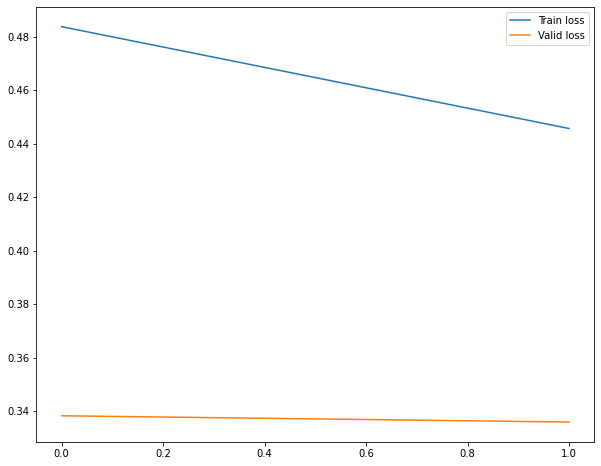

In [36]:
# visualize Result
plt.figure(figsize=(10,8))
plt.plot([loss.cpu().data for loss in train_loss], label='Train loss')
plt.plot([loss.cpu().data for loss in valid_loss], label='Valid loss')
plt.legend()

## 3. DenseUnet

### 3.1 Model

In [37]:
class Single_level_densenet(nn.Module):
    def __init__(self,filters, num_conv = 4):
        super(Single_level_densenet, self).__init__()
        self.num_conv = num_conv
        self.conv_list = nn.ModuleList()
        self.bn_list = nn.ModuleList()
        for i in range(self.num_conv):
            self.conv_list.append(nn.Conv2d(filters,filters,3, padding = 1))
            self.bn_list.append(nn.BatchNorm2d(filters))
            
    def forward(self,x):
        outs = []
        outs.append(x)
        for i in range(self.num_conv):
            temp_out = self.conv_list[i](outs[i])
            if i > 0:
                for j in range(i):
                    temp_out += outs[j]
            outs.append(F.relu(self.bn_list[i](temp_out)))
        out_final = outs[-1]
        del outs
        return out_final
    
class Down_sample(nn.Module):
    def __init__(self,kernel_size = 2, stride = 2):
        super(Down_sample, self).__init__()
        self.down_sample_layer = nn.MaxPool2d(kernel_size, stride)
    
    def forward(self,x):
        y = self.down_sample_layer(x)
        return y,x

class Upsample_n_Concat(nn.Module):
    def __init__(self,filters):
        super(Upsample_n_Concat, self).__init__()
        self.upsample_layer = nn.ConvTranspose2d(filters, filters, 4, padding = 1, stride = 2)
        self.conv = nn.Conv2d(2*filters,filters,3, padding = 1)
        self.bn = nn.BatchNorm2d(filters)
    
    def forward(self,x,y):
        x = self.upsample_layer(x)
        x = torch.cat([x,y],dim = 1)
        x = F.relu(self.bn(self.conv(x)))
        return x
    

class Dense_Unet(nn.Module):
    def __init__(self, in_chan, out_chan, filters, num_conv = 4):
        super(Dense_Unet, self).__init__()
        self.conv1 = nn.Conv2d(in_chan,filters,1)
        self.d1 = Single_level_densenet(filters,num_conv )
        self.down1 = Down_sample()
        self.d2 = Single_level_densenet(filters,num_conv )
        self.down2 = Down_sample()
        self.d3 = Single_level_densenet(filters,num_conv )
        self.down3 = Down_sample()
        self.d4 = Single_level_densenet(filters,num_conv )
        self.down4 = Down_sample()
        self.bottom = Single_level_densenet(filters,num_conv )
        self.up4 = Upsample_n_Concat(filters)
        self.u4 = Single_level_densenet(filters,num_conv )
        self.up3 = Upsample_n_Concat(filters)
        self.u3 = Single_level_densenet(filters,num_conv )
        self.up2 = Upsample_n_Concat(filters)
        self.u2 = Single_level_densenet(filters,num_conv )
        self.up1 = Upsample_n_Concat(filters)
        self.u1 = Single_level_densenet(filters,num_conv )
        self.outconv = nn.Conv2d(filters,out_chan, 1)
#         self.outconvp1 = nn.Conv2d(filters,out_chan, 1)
#         self.outconvm1 = nn.Conv2d(filters,out_chan, 1)
        
        
    def forward(self,x):
        bsz = x.shape[0]
        x = self.conv1(x)
        x,y1 = self.down1(self.d1(x))
        x,y2 = self.down1(self.d2(x))
        x,y3 = self.down1(self.d3(x))
        x,y4 = self.down1(self.d4(x))
        x = self.bottom(x)
        x = self.u4(self.up4(x,y4))
        x = self.u3(self.up3(x,y3))
        x = self.u2(self.up2(x,y2))
        x = self.u1(self.up1(x,y1))
        x1 = self.outconv(x)
#         xm1 = self.outconvm1(x)
#         xp1 = self.outconvp1(x)
        
        return x1

In [42]:
denseunet = Dense_Unet(4, 4, 6)

In [43]:
# testing one pass
xb, yb = next(iter(train_dataload))
xb.shape, yb.shape

pred = denseunet(xb)
pred.shape

torch.Size([3, 4, 384, 384])

### 3.2 Training

In [44]:
loss_fn = nn.CrossEntropyLoss() # choose loss function
opt = torch.optim.Adam(denseunet.parameters(), lr=0.01) # choose gradient function

# start training
train_loss, valid_loss = train(denseunet, train_dataload, valid_dataload, loss_fn, opt, acc_metric, epochs=2)

Epoch 1/1
----------
valid Loss: 0.3591 Acc: 0.7570909261703491
----------
Training complete in 0m 43s


In [45]:
train_loss

[tensor(0.5494, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.4162, device='cuda:0', grad_fn=<DivBackward0>)]

In [46]:
valid_loss

[tensor(0.3339, device='cuda:0'), tensor(0.3591, device='cuda:0')]

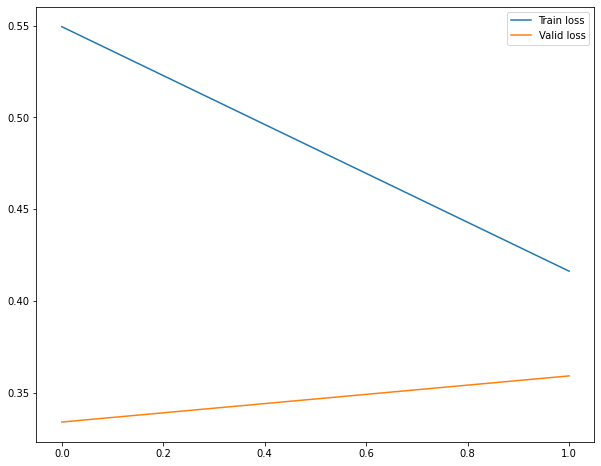

In [47]:
# visualize Result
plt.figure(figsize=(10,8))
plt.plot([loss.cpu().data for loss in train_loss], label='Train loss')
plt.plot([loss.cpu().data for loss in valid_loss], label='Valid loss')
plt.legend()

## 4. UNET Version 3 ([From UNET++](https://github.com/bigmb/Unet-Segmentation-Pytorch-Nest-of-Unets/blob/master/Models.py))

### 4.1 Model

In [14]:
class conv_block(nn.Module):
    """
    Convolution Block 
    """
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):

        x = self.conv(x)
        return x


class up_conv(nn.Module):
    """
    Up Convolution Block
    """
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x


class U_Net(nn.Module):
    """
    UNet - Basic Implementation
    Paper : https://arxiv.org/abs/1505.04597
    """
    def __init__(self, in_ch=3, out_ch=1):
        super(U_Net, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]
        
        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(in_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], out_ch, kernel_size=1, stride=1, padding=0)

       # self.active = torch.nn.Sigmoid()

    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)
        d5 = torch.cat((e4, d5), dim=1)

        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        d4 = torch.cat((e3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((e2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((e1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

        #d1 = self.active(out)

        return out

In [49]:
u_net = U_Net(4, 2)

In [50]:
# testing one pass
xb, yb = next(iter(train_dataload))
xb.shape, yb.shape

pred = u_net(xb)
pred.shape

torch.Size([3, 2, 384, 384])

### 4.2 Training

In [51]:
loss_fn = nn.CrossEntropyLoss() # choose loss function
opt = torch.optim.Adam(u_net.parameters(), lr=0.01) # choose gradient function

# start training
train_loss, valid_loss = train(u_net, train_dataload, valid_dataload, loss_fn, opt, acc_metric, epochs=2)

Epoch 1/1
----------
valid Loss: 0.3097 Acc: 0.7986529469490051
----------
Training complete in 3m 49s


In [52]:
train_loss

[tensor(0.4765, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.4099, device='cuda:0', grad_fn=<DivBackward0>)]

In [53]:
valid_loss

[tensor(0.9221, device='cuda:0'), tensor(0.3097, device='cuda:0')]

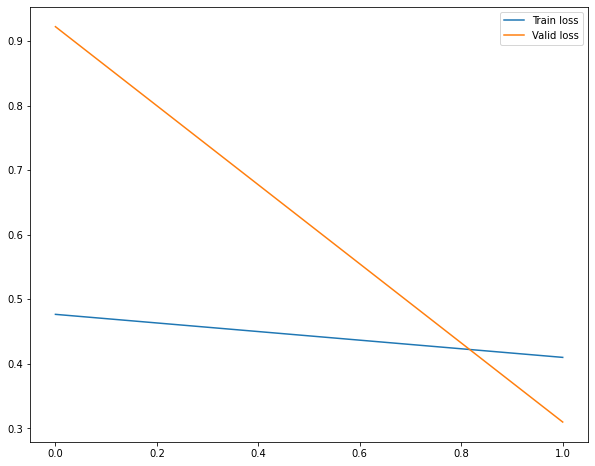

In [54]:
# visualize Result
plt.figure(figsize=(10,8))
plt.plot([loss.cpu().data for loss in train_loss], label='Train loss')
plt.plot([loss.cpu().data for loss in valid_loss], label='Valid loss')
plt.legend()

## 5. UNET++

### 5.1 Model

In [15]:
class conv_block_nested(nn.Module):
    
    def __init__(self, in_ch, mid_ch, out_ch):
        super(conv_block_nested, self).__init__()
        self.activation = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_ch, mid_ch, kernel_size=3, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(mid_ch)
        self.conv2 = nn.Conv2d(mid_ch, out_ch, kernel_size=3, padding=1, bias=True)
        self.bn2 = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        output = self.activation(x)

        return output

class NestedUNet(nn.Module):
    """
    Implementation of this paper:
    https://arxiv.org/pdf/1807.10165.pdf
    """
    def __init__(self, in_ch=3, out_ch=1):
        super(NestedUNet, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = conv_block_nested(in_ch, filters[0], filters[0])
        self.conv1_0 = conv_block_nested(filters[0], filters[1], filters[1])
        self.conv2_0 = conv_block_nested(filters[1], filters[2], filters[2])
        self.conv3_0 = conv_block_nested(filters[2], filters[3], filters[3])
        self.conv4_0 = conv_block_nested(filters[3], filters[4], filters[4])

        self.conv0_1 = conv_block_nested(filters[0] + filters[1], filters[0], filters[0])
        self.conv1_1 = conv_block_nested(filters[1] + filters[2], filters[1], filters[1])
        self.conv2_1 = conv_block_nested(filters[2] + filters[3], filters[2], filters[2])
        self.conv3_1 = conv_block_nested(filters[3] + filters[4], filters[3], filters[3])

        self.conv0_2 = conv_block_nested(filters[0]*2 + filters[1], filters[0], filters[0])
        self.conv1_2 = conv_block_nested(filters[1]*2 + filters[2], filters[1], filters[1])
        self.conv2_2 = conv_block_nested(filters[2]*2 + filters[3], filters[2], filters[2])

        self.conv0_3 = conv_block_nested(filters[0]*3 + filters[1], filters[0], filters[0])
        self.conv1_3 = conv_block_nested(filters[1]*3 + filters[2], filters[1], filters[1])

        self.conv0_4 = conv_block_nested(filters[0]*4 + filters[1], filters[0], filters[0])

        self.final = nn.Conv2d(filters[0], out_ch, kernel_size=1)


    def forward(self, x):
        
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.Up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.Up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.Up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.Up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.Up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.Up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.Up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.Up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.Up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.Up(x1_3)], 1))

        output = self.final(x0_4)
        return output

In [16]:
nestedunet = NestedUNet(4, 2)

In [17]:
# testing one pass
xb, yb = next(iter(train_dataload))
xb.shape, yb.shape

pred = nestedunet(xb)
pred.shape

torch.Size([3, 2, 384, 384])

### 5.2 Training

In [20]:
loss_fn = nn.CrossEntropyLoss() # choose loss function
opt = torch.optim.Adam(nestedunet.parameters(), lr=0.01) # choose gradient function

# start training
train_loss, valid_loss = train(nestedunet, train_dataload, valid_dataload, loss_fn, opt, acc_metric, epochs=2)

Epoch 1/1
----------
valid Loss: 0.3451 Acc: 0.8246662020683289
----------
Training complete in 8m 24s


In [21]:
train_loss

[tensor(0.4514, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.4193, device='cuda:0', grad_fn=<DivBackward0>)]

In [22]:
valid_loss

[tensor(0.3448, device='cuda:0'), tensor(0.3451, device='cuda:0')]

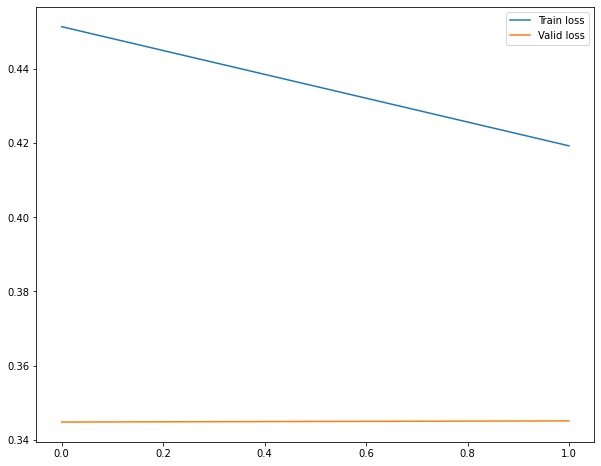

In [23]:
# visualize Result
plt.figure(figsize=(10,8))
plt.plot([loss.cpu().data for loss in train_loss], label='Train loss')
plt.plot([loss.cpu().data for loss in valid_loss], label='Valid loss')
plt.legend()